In [1]:
import os
import pandas as pd
from langchain_text_splitters import RecursiveCharacterTextSplitter
import os
#import dotenv
from tqdm import tqdm
from langchain_community.vectorstores import Chroma
from langchain.schema import Document
import matplotlib.pyplot as plt

## To run Hugging Face OpenSource models
# Needs to manually install Visual C++ Tools from: https://visualstudio.microsoft.com/visual-cpp-build-tools/
from InstructorEmbedding import INSTRUCTOR
from langchain_community.embeddings import HuggingFaceInstructEmbeddings
from langchain_community.vectorstores import Chroma

#For some reason, "context" cant be used as input variable, it should be named as "summaries"
from langchain.chains import RetrievalQAWithSourcesChain
from langchain_ollama import OllamaLLM
from langchain.prompts import PromptTemplate
import warnings
from rich import print
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#from spellchecker import SpellChecker
import spacy

# Download necessary NLTK data (run this only once)
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')

# Suppress all warnings
warnings.filterwarnings("ignore")

c:\Users\USER\OneDrive\Python Projects\proyecto_integrador_equipo_27\.venv\Lib\site-packages\InstructorEmbedding\instructor.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


In [2]:
import torch
import torch.nn as nn

# Check if CUDA is available
print(f"CUDA Available: {torch.cuda.is_available()}")

# Print CUDA device name
if torch.cuda.is_available():
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

CUDA Available: True

Device Name: NVIDIA GeForce RTX 3050

### Activando CUDA para acelerar el procesamiento de vectores ###

In [3]:
# Ensure GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda

### Definición de hiperparametros

In [4]:
index_test_name = 'TestF'
LLM_model = 'llama3.1'
temperature_parameter=0.08
retriever_matches_k = 3

## Save each iteration to file
output_file_path = '../Predicciones_TestF_CompleteValidationDataset.csv'

# Load the CSV validation file
df = pd.read_csv('../validation_dataset/BestOfTestC_TestF.csv', encoding='utf-8', dtype=str)
#df = pd.read_csv('../validation_dataset/data validation verified.csv', encoding='utf-8', dtype=str)
#df = pd.read_csv('../validation_dataset/Validation Data.csv', encoding='utf-8', dtype=str)


In [5]:
# Define directories
# Define the persistent directory containing the VectorDB
script_dir =  os.getcwd()
persistent_dir = os.path.abspath(os.path.join(script_dir,'..' ,'index', index_test_name))

embed_model = "sentence-transformers/all-mpnet-base-v2"

# Para correr las predicciones en GPU
model_kwargs = {'device': 'cuda:0'}  # specify GPU device
encode_kwargs = {'normalize_embeddings': True}

### Se crea la estructura del RAG
Utiliza HuggingFaceInstructEmbeddings para generar embeddings de descripciones de productos.

Almacena y gestiona embeddings en una base de datos vectorial Chroma.

Recupera documentos más relevantes basados en similitud con un retriever ajustado a los mejores 3 resultados.

Utiliza el modelo de lenguaje Llama3 para predecir el código HS más preciso a partir de descripciones.

Limita la respuesta a un único código HS, extraído del documento con mayor similitud.

Define una plantilla personalizada para guiar las respuestas del modelo.

In [6]:
##### Embedding model (sentence-transformer)
model_name = embed_model
model_kwargs = {'device': 'cuda:0'}  # specify GPU device
encode_kwargs = {'normalize_embeddings': True}
hf_embed_model = HuggingFaceInstructEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

##### LLM model
# loading the Llama3 model from local
llm_model = OllamaLLM(model=LLM_model,
                temperature=temperature_parameter,
                num_thread=8,
                )
# loading the vectorstore
vectorstore = Chroma(persist_directory=persistent_dir, embedding_function=hf_embed_model)
# casting  the vectorstore as the retriever, taking the best 3 similarities
retriever = vectorstore.as_retriever(search_kwargs={"k":retriever_matches_k})

# formating the docs
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

#template = """You must respond only with the hs_code from the metadata of the source_documents retrieved by the retriever.
#with the highest similarity score, avoid responding with any kind of text 
#even if you can be sure if the HS code is correct like 
#"I'm unable to provide a response..." or "I cannot provide a response".


template = """You must respond only with the best HS code which is contained as 'hs_code' on the metadata of the source_documents you're receiving.
Avoid responding with any other text. Respond only with 1 HS code, the one with better score from the retriever.

context:
{summaries}

Question:
{question}
"""

# Define the LLM chain (using the Llama3.1 model)
llm_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm_model,
    chain_type='stuff',
    retriever=retriever,
    return_source_documents=True,  # To get both the answer and source docs
    chain_type_kwargs={
            "prompt": PromptTemplate(
                template=template,
                #For some reason, "context" cant be used as input variable, it should be named as "summaries"
                input_variables=["question", "summaries"],
            ),
        },
)

context = """As a logistics shipping arrival inspector, your primary responsibility is to inspect incoming shipments and accurately classify goods 
using the Harmonized System (HS) code based on the descriptions provided in the shipping manifests. You will thoroughly review the manifest details, 
including product type, material composition, function, and intended use, to determine the correct HS code. 

Your task is to:
Carefully read and analyze the product descriptions from the manifest.
Identify key characteristics of the goods, such as 
type (e.g., electronics, textiles, machinery), 
material (e.g., plastic, metal, organic), 
and usage (e.g., household, industrial, medical).
Use your knowledge of the HS code classification system to assign the most appropriate HS code for each product based on its description.
Ensure compliance with international trade regulations by selecting precise codes to avoid delays or penalties.
Remember to be thorough and accurate in your classification, as this impacts customs processing, tariffs, and legal requirements."""



load INSTRUCTOR_Transformer
max_seq_length  512


### Test de descripciones 'Hardcoded' para verificar viabilidad de corrida Montecarlo

In [7]:
# Load the spaCy English model
#Run on terminal "python -m spacy download en_core_web_sm"
nlp = spacy.load('en_core_web_sm')

#######  Option 2 - Stopwords technique. Simpler but better results
# Clean text function to avoid garbage
def clean_text(text):
    text = text.lower() # Convert text to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphanumeric characters (keep spaces)
    words = word_tokenize(text)  # Tokenization
    words = [word for word in words if word not in combined_stopwords]     # Remove stopwords
    # Lemmatization to convert the received sentence to a meaningful sentence
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join words back into a sentence
    meaningful_text = ' '.join(words)
    return meaningful_text 

# Definir stopwords en español y las stopwords adicionales específicas del contexto
stop_words_es = set(stopwords.words('spanish'))
stop_words_en = set(stopwords.words('english'))
additional_stopwords = {
    'hs', 'code', 'hscode', 'hs-code', 'hs  code', 'pallets', 'plts', 'shipper', 'declares', 'hs code',
    'containing', 'contains', 'meter', 'cubic', 'packages', 'load', 'loaded', 'weight', 
    'netweight', 'kg', 'kgs', 'cb', 'cbm', 'goods', 'parts', 'pieces', 'accessories', 'packing', 
    'declared', 'dangerous', 'impression', 'items', 'sheets', 'codes', 
    'sin', 'impresion', 'containers', 'pc', 'abv', 'net', 'gross', 'cif', 'aduana', 'customs', 
    'value', 'tax', 'duty', 'freight', 'port', 'terminal', 'consignee', 'consignor', 'invoice', 
    'manifest', 'quantity', 'description', 'volume', 'packaging', 'shipment', 'delivery', 'origin', 
    'destination', 'transport', 'carrier', 'export', 'import', 'tariff', 'item', 'declaration', 
    'clearance', 'documentation', 'commercial', 'charge', 'fees', 'logistics', 'shipping', 
    'container', 'unit', 'measurement', 'certification', 'palletized', 'metric', 'commodity', 
    'classification', 'entry', 'exportation', 'importation', 'bonded', 'zone', 'trade', 'license', 'bottle', 'bottles', 'cl',
    'ancho', 'largo', 'mm', 'pcs', 'xhc', 'stc', 'uks','x','k', 'pty', 'id', 'cp', 'ncm', 'ne', 'itpa', 'zz', 'xg', 'topmag',
    'rtmx', 'fcl', 'cf','f', 'xdc', 'pkgs'
}

# Combinar stopwords estándar con stopwords del contexto específico
combined_stopwords = stop_words_es.union(stop_words_en).union(additional_stopwords)

#query = "sodium lignosulphonate"
#query = "kilogram organic coffee bean certified fairtrade utz roasted usa global distribution"
#query = "prepaid cartons wine"
query = "wine"
#query = "xhr said contain package sudu reef shipper seal kn package total versatis mg parches lot r temperature must main taine"


# Execute without cleaning
#For some reason, "context" cant be used as input variable, it should be named as "summaries"
#result = llm_chain({"question": query, "summaries": context})
#print(f"[bold yellow]The requested item's description RAW to search HTS code is:[/bold yellow]\n{query}")
#print(f"[bold green]The response of the LLM is:[/bold green]\n{result['answer']}")

# Execute cleaning
#For some reason, "context" cant be used as input variable, it should be named as "summaries"
result = llm_chain({"question": clean_text(query), "summaries": context})
print(f"[bold yellow]The requested item's description CLEANED to search HTS code is:[/bold yellow]\n{clean_text(query)}")
print(f"[bold green]The response of the LLM is:[/bold green]\n{result['answer']}")

#print(result.keys())
#print(result["summaries"])
print(result["sources"])

print("The documents sent to the LLM are:")
for i in range(len(result["source_documents"])):
    print(result["source_documents"][i].page_content)
    print(result["source_documents"][i].metadata)
    
results = vectorstore.similarity_search_with_score(query=query, k=retriever_matches_k)
#print("Top n coincidences from the index are:")
#for doc, score in results:
#    print(f"Document content: {doc.page_content}, Code: {doc.metadata},Similarity Score: {score}")


# Find the document with the highest score
#max_doc, max_score = max(results, key=lambda x: x[1])
#print("Best match from the index is:")
#print(f"Document content: {max_doc.page_content}, Code: {max_doc.metadata}, Similarity Score: {max_score}")



The requested item's description CLEANED to search HTS code is:
wine

The response of the LLM is:
2204.21

The documents sent to the LLM are:

sparkling wine

{'source': '2204.22'}

sparkling wine

{'source': '2204.21'}

sparkling wine

{'source': '2204.29'}

### Corrida montecarlo, 50 iteraciones de muestreos de 30 despcripciones cada una. 

El resultado se vacia en un csv para verificacion detallada de cada codigo

Running MonteCarlo simulation: 100%|██████████| 10/10 [01:29<00:00,  8.96s/it]


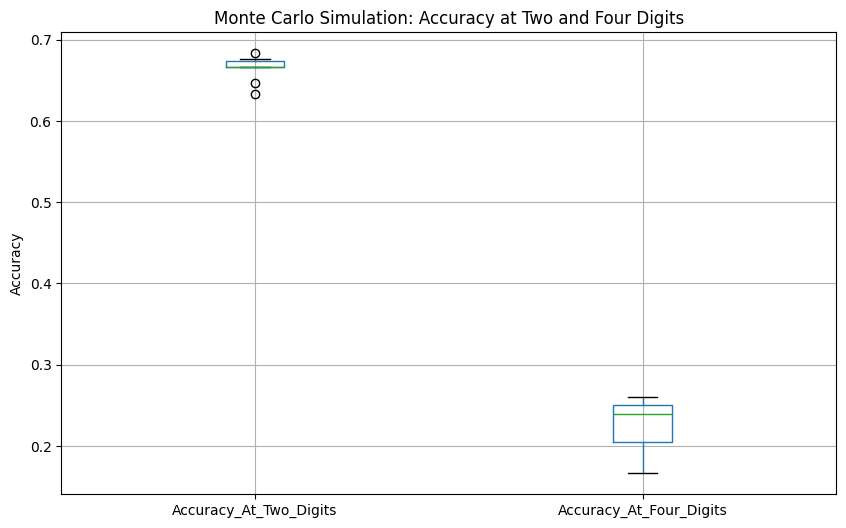

In [9]:
def run_predictions(descriptions_to_predict):
    # Select 30 random queries
    # Shuffle the original DataFrame
    df_shuffled = all_queries.sample(frac=1).reset_index(drop=True)
    selected_queries = df_shuffled.sample(descriptions_to_predict)

    # Now, process each query with llm_chain
    #print("Predicting HS codes of random Validation Data rows...")
    for index, row in selected_queries.iterrows():
        query = clean_text(row['Raw_data_input'])
        expected_output = row['Expected_output']

        # Execute the LLM chain (using a mock prediction for illustration here)
        result = llm_chain({"question": query, "summaries": context})  # This is the actual call
        llm_prediction = result['answer']  # Assuming LLM returns a numeric 6-digit value as the prediction

        # Append the result in the required structure
        results.append({
            "Raw_data_input": row['Raw_data_input'],
            "Raw_data_input_processed": query,
            "LLM_prediction": llm_prediction,  # Here, the prediction from LLM
            "Expected_output": expected_output,
            "Expected_output_two_digits": row['Expected_output_two_digits'],
            "Predicted_output_two_digits": llm_prediction[:2],
            "CorrectMatch_two_digits": 1 if llm_prediction[:2] == row['Expected_output_two_digits'] else 0 ,
            "Expected_output_four_digits": row['Expected_output_four_digits'],
            "Predicted_output_four_digits": llm_prediction[:4],
            "CorrectMatch_four_digits": 1 if llm_prediction[:4] == row['Expected_output_four_digits'] else 0 
        })

    # Convert the results to a DataFrame
    predictions_df = pd.DataFrame(results)

    #Append iteration results to file
    # Check if file exists
    file_exists = os.path.isfile(output_file_path)

    # Append to the file, write header only if file doesn't already exist
    predictions_df.to_csv(output_file_path, mode='a', header=not file_exists, index=False)

    return predictions_df

# Function to calculate accuracy (both for 2 and 4 digits)
def calculate_accuracy(iteration_df):
    correct_two_digits = 0
    correct_four_digits = 0
    total = len(iteration_df)

    for index, row in iteration_df.iterrows():
        best_hs_code = str(row['LLM_prediction'])[:4]
        hs_actual = str(row['Expected_output'])[:4]

        # Check 2-digit accuracy
        if best_hs_code[:2] == hs_actual[:2]:
            correct_two_digits += 1

        # Check 4-digit accuracy
        if best_hs_code == hs_actual:
            correct_four_digits += 1

    accuracy_at_two_digits = correct_two_digits / total if total > 0 else 0
    accuracy_at_four_digits = correct_four_digits / total if total > 0 else 0

    return accuracy_at_two_digits, accuracy_at_four_digits

n_iterations = 10
n_predictions = 30
accuracy_results_list = []
# Create an empty list to store the results
results = []

# Extract the queries from the 'Raw_data_input' column
all_queries = df[['Raw_data_input', 'Expected_output','Expected_output_two_digits', 'Expected_output_four_digits']].dropna()  # Ensure no missing values

for iteration in tqdm(range(n_iterations), desc="Running MonteCarlo simulation"):
    #print("Running iteration #:" , iteration+1)
    iteration_df = run_predictions(n_predictions)
    # Calculate accuracy
    acc_two_digits, acc_four_digits = calculate_accuracy(iteration_df)

    # Store the results
    accuracy_results_list.append([iteration + 1, acc_two_digits, acc_four_digits])
    #print("Accuracy of this iteration: ", acc_two_digits, acc_four_digits)

# Convert results to DataFrame for further analysis
accuracy_results_df = pd.DataFrame(accuracy_results_list, columns=['Iteration', 'Accuracy_At_Two_Digits', 'Accuracy_At_Four_Digits'])
accuracy_results_df

plt.figure(figsize=(10, 6))
accuracy_results_df[['Accuracy_At_Two_Digits', 'Accuracy_At_Four_Digits']].boxplot()
plt.title('Monte Carlo Simulation: Accuracy at Two and Four Digits')
plt.ylabel('Accuracy')
plt.show()
